In [1]:
import pandas as pd 
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.oneway import anova_oneway

warnings.filterwarnings('ignore')

# 시각화 환경
sns.set(style='whitegrid', palette='pastel')
plt.rcParams['font.family'] = 'Malgun Gothic'   
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def pre_process(df: pd.DataFrame) -> pd.DataFrame:
    '''
    데이터 전처리 함수
    - 결측치 처리, 데이터 타입 변환, 매핑, 파생변수 생성, 기본 지표 계산까지 수행
    Args:
        df (pd.DataFrame): 원본 데이터프레임
    Returns:
        pd.DataFrame: 전처리 완료된 데이터프레임
    '''

    # 1. 결측치 처리
    df['사업장_시도'] = df['사업장_시도'].fillna('미정')
    df['사업장_시군구'] = df['사업장_시군구'].fillna('미정')

    # 2. 기준년월 변환 (YYYYMM → PeriodIndex[월])
    df['기준년월'] = pd.to_datetime(df['기준년월'].astype(str), format='%Y%m', errors='coerce')
    df['기준년월'] = df['기준년월'].dt.to_period('M')  # "2024-12" 형태 유지

    # 3. 대구/경북 여부 플래그
    df['대구경북권_여부'] = df['사업장_시도'].isin(['대구광역시', '경상북도'])

    # 4. 전담고객여부 매핑 (Y/N → True/False)
    df['전담고객여부'] = df['전담고객여부'].map({'N': False, 'Y': True})

    # 5. 좌수 범주 → 숫자 매핑
    seat_map = {
        "0개": 0, "1개": 1, "2개": 2,
        "2개초과 5개이하": 4, "5개초과 10개이하": 8,
        "10개초과 20개이하": 15.5, "20개초과 30개이하": 25.5,
        "30개초과 40개이하": 35.5, "40개초과 50개이하": 45.5,
        "50개 초과": 55
    }
    cols_to_map = [
        "요구불예금좌수","거치식예금좌수","적립식예금좌수",
        "수익증권좌수","신탁좌수","퇴직연금좌수",
        "여신_운전자금대출좌수","여신_시설자금대출좌수","신용카드개수"
    ]
    df[cols_to_map] = df[cols_to_map].replace(seat_map)

    # 6. 거래건수 범주 → 숫자 매핑
    txn_map = {
        "0건": 0, "1건": 1, "2건": 2,
        "2건초과 5건이하": 3, "5건초과 10건이하": 7,
        "10건초과 20건이하": 15, "20건초과 30건이하": 25,
        "30건초과 40건이하": 35, "40건초과 50건이하": 45,
        "50건 초과": 60
    }
    cols_to_map = [
        "외환_수출실적거래건수","외환_수입실적거래건수",
        "창구거래건수","인터넷뱅킹거래건수","스마트뱅킹거래건수",
        "폰뱅킹거래건수","ATM거래건수","자동이체거래건수"
    ]
    df[cols_to_map] = df[cols_to_map].replace(txn_map)

    # 7. 파생 변수 생성
    df['총거래건수'] = df[['창구거래건수','인터넷뱅킹거래건수','스마트뱅킹거래건수',
                         '폰뱅킹거래건수','ATM거래건수','자동이체거래건수']].sum(axis=1)
    df['총잔액'] = df[['요구불예금잔액','거치식예금잔액','적립식예금잔액']].sum(axis=1)
    df['여신잔액'] = df[['여신_운전자금대출잔액','여신_시설자금대출잔액']].sum(axis=1)
    df['외환거래총금액'] = df[['외환_수출실적금액','외환_수입실적금액']].sum(axis=1)
    df['수탁상품총잔액'] = df[['수익증권잔액','신탁잔액','퇴직연금잔액']].sum(axis=1)
    df['카드사용총금액'] = df[['신용카드사용금액','체크카드사용금액']].sum(axis=1)

    # 8. 여신이용률
    df['여신이용률'] = np.where(df['여신한도금액'] == 0, 0, df['여신잔액'] / df['여신한도금액'])

    # 9. 디지털 거래건수 & 비중
    df['디지털거래건수'] = df[['인터넷뱅킹거래건수','스마트뱅킹거래건수',
                            '폰뱅킹거래건수','자동이체거래건수']].sum(axis=1)

    def calc_digital_ratio(row: pd.Series) -> float:
        if row['총거래건수'] == 0:
            return 0.0 if row['디지털거래건수'] == 0 else pd.NA
        return row['디지털거래건수'] / row['총거래건수']

    df['디지털비중'] = df.apply(calc_digital_ratio, axis=1)

    # 10. 창구비중, 요구불회전율
    df['창구비중'] = np.where(df['총거래건수'] == 0, 0, df['창구거래건수'] / df['총거래건수'])
    df['요구불회전율'] = np.where(df['요구불예금잔액'] == 0, 0,
                               (df['요구불입금금액'] + df['요구불출금금액']) / df['요구불예금잔액'])

    # 11. 수치형 컬럼 강제 변환
    cols_numeric = ['여신이용률','디지털비중','창구비중','요구불회전율']
    for col in cols_numeric:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 12. 예대마진 계산
    loan_rate = 0.05
    deposit_rate = 0.02
    df["예대마진"] = (df["여신_운전자금대출잔액"] + df["여신_시설자금대출잔액"]) * loan_rate \
                   - df["총잔액"] * deposit_rate

    return df

In [3]:
df = pd.read_csv("C:\\Users\\seomi\\바탕 화면\\iM Digital academy\\Project\\Analysis of corporate data\\cor_data.csv", encoding='cp949')
pre_process(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347299 entries, 0 to 347298
Data columns (total 58 columns):
 #   Column       Non-Null Count   Dtype    
---  ------       --------------   -----    
 0   기준년월         347299 non-null  period[M]
 1   업종_대분류       347299 non-null  object   
 2   업종_중분류       347299 non-null  object   
 3   사업장_시도       347299 non-null  object   
 4   사업장_시군구      347299 non-null  object   
 5   법인_고객등급      347299 non-null  object   
 6   전담고객여부       347299 non-null  bool     
 7   요구불예금잔액      347299 non-null  float64  
 8   거치식예금잔액      347299 non-null  float64  
 9   적립식예금잔액      347299 non-null  float64  
 10  수익증권잔액       347299 non-null  float64  
 11  신탁잔액         347299 non-null  float64  
 12  퇴직연금잔액       347299 non-null  float64  
 13  여신한도금액       347299 non-null  float64  
 14  여신_운전자금대출잔액  347299 non-null  float64  
 15  여신_시설자금대출잔액  347299 non-null  float64  
 16  외환_수출실적금액    347299 non-null  float64  
 17  외환_수입실적금액    347299 non-null 

# 업종 별로 예대마진의 차이가 있는 지 궁금하다 

,mean,median,std,count
업종_대분류,,,,
금융 및 보험업,-688.727694,39.9938,7581.720579,3281
보건업 및 사회복지 서비스업,-12.640067,-0.0199,276.182775,1810
"농업, 임업 및 어업",16.605242,7.4680,21.763860,1195
교육 서비스업,17.855927,2.5888,74.157192,4353
"전문, 과학 및 기술 서비스업",24.850308,4.2496,92.892002,9388
정보통신업,26.094380,7.4834,93.832459,7385
"사업시설 관리, 사업 지원 및 임대 서비스업",26.390306,2.1448,123.356677,11820
"협회 및 단체, 수리 및 기타 개인 서비스업",29.518744,-0.0032,176.127153,7101
"전기, 가스, 증기 및 공기조절 공급업",31.450909,9.4980,145.457807,1776


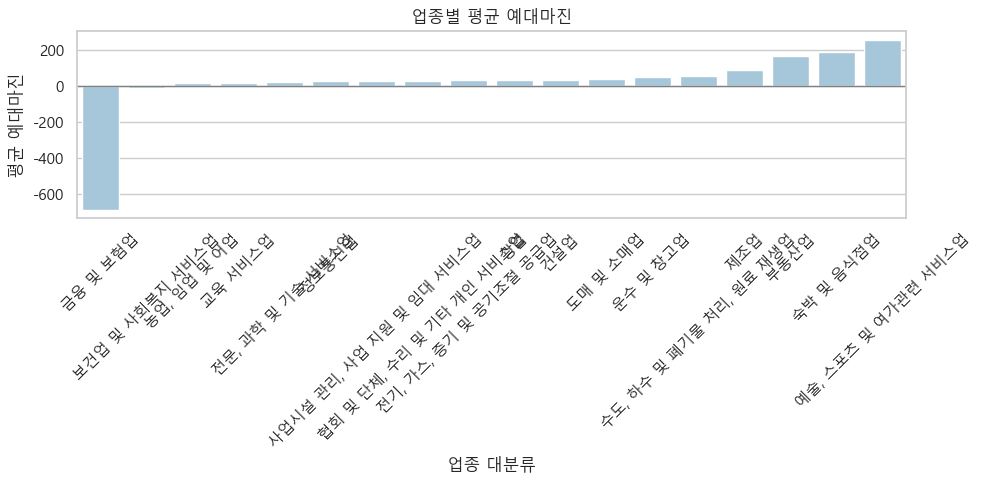

In [4]:
# 0) 안전 보정
if '업종_대분류' not in df.columns or '예대마진' not in df.columns:
    raise KeyError("필수 컬럼(업종_대분류, 예대마진) 누락")
df['예대마진'] = pd.to_numeric(df['예대마진'], errors='coerce')

# 1) 업종별 예대마진 요약 (평균/중앙/분산)
nim_by_ind = (
    df.groupby('업종_대분류', dropna=False)['예대마진']
      .agg(mean='mean', median='median', std='std', count='size')
      .sort_values('mean')
)
display(nim_by_ind)  # 업종별 예대마진 요약 테이블

# 2) 시각화: 업종별 평균 예대마진 Bar Plot
plt.figure(figsize=(10, 5))
sns.barplot(
    data=nim_by_ind.reset_index(),
    x='업종_대분류', y='mean', color='#9ecae1'
)
plt.axhline(0, color='gray', lw=1)
plt.title('업종별 평균 예대마진')
plt.xlabel('업종 대분류')
plt.ylabel('평균 예대마진')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

업종별로 차이가 있는 것 같다.

이게 확실한 지 가설검증을 하자.

# 가설검정

In [5]:
groups = [g['예대마진'].values for _, g in df.groupby('업종_대분류')]
lev_stat, lev_p = stats.levene(*groups, center='median')
print(f"Levene 등분산성 검정: W={lev_stat:.4f}, p={lev_p:.4g}")

Levene 등분산성 검정: W=575.5117, p=0


In [6]:
from statsmodels.stats.oneway import anova_oneway
def welch_anova(df, dv="예대마진", group="업종_대분류"):
    tmp = df[[dv, group]].dropna()
    y = pd.to_numeric(tmp[dv], errors="coerce").dropna().to_numpy()
    g = tmp.loc[tmp[dv].notna(), group].astype("category").to_numpy()
    res = anova_oneway(y, g, use_var="unequal", welch_correction=True)  # Welch ANOVA
    print(f"Welch ANOVA: F({res.df_num:.2f}, {res.df_denom:.2f})={res.statistic:.4f}, p={res.pvalue:.4g}")
    return res
# 사용 예
welch_anova(df, dv="예대마진", group="업종_대분류")

Welch ANOVA: F(17.00, 19924.67)=813.0593, p=0


<class 'statsmodels.stats.base.HolderTuple'>
statistic = np.float64(813.0592719946063)
pvalue = np.float64(0.0)
df = (17.0, np.float64(19924.67189187302))
df_num = 17.0
df_denom = np.float64(19924.67189187302)
nobs_t = np.float64(347299.0)
n_groups = 18
means = array([  32.53373005,   31.78078471,   17.85592743, -688.72769427,
             16.60524226,   40.53607794,  -12.64006707,  169.04933016,
             26.39030603,   57.77670339,  187.33196537,  257.55479063,
             48.65670631,   31.45090901,   24.85030755,   26.0943797 ,
             91.16571921,   29.51874433])
nobs = array([ 51258.,    484.,   4353.,   3281.,   1195.,  65623.,   1810.,
            31749.,  11820.,   4331.,   8082.,   3651.,  12798.,   1776.,
             9388.,   7385., 121214.,   7101.])
vars_ = array([7.06716880e+04, 3.45064574e+03, 5.49928919e+03, 5.74824869e+07,
           4.73665581e+02, 1.47966410e+04, 7.62769251e+04, 1.07767614e+05,
           1.52168697e+04, 1.81979439e+04, 2.07883395e+05, 3.82

Levene 위배 → Welch ANOVA로 전체 검정

“Welch ANOVA 결과, 업종 간 예대마진 평균 차이가 통계적으로 유의하였다(F(df1, df2)=F, p<0.05).”

➡️ 귀무가설 기각, 업종별 예대마진 차이 존재

5️⃣ 종합 결론

업종별 차이는 통계적으로 매우 유의 (p<0.001)

손실 업종: 금융·보험업(-802), 보건업(-46), 협회·단체(-3.7) → 구조적 적자 고객군

우량 업종: 부동산업(+168), 숙박·음식점업(+186), 예술·스포츠·여가(+244) → 주요 수익원

💡 전략적 시사점

적자 업종 관리: RM 배정 효율화, 여신 활용 낮은 고객군은 모니터링 강화

우량 업종 집중: 부동산·숙박·예술 고객군 대상 교차판매·장기 거래 유도

# 추가 분석 (손실 업종의 특징을 분석해보자)

In [7]:
# 평균이 0보다 낮은 업종만 필터링
negative_inds = ["금융 및 보험업", "보건업 및 사회복지 서비스업", "협회 및 단체, 수리 및 기타 개인 서비스업"]
d_neg = df[df['업종_대분류'].isin(negative_inds)].copy()
print(d_neg['업종_대분류'].value_counts())

업종_대분류
협회 및 단체, 수리 및 기타 개인 서비스업    7101
금융 및 보험업                    3281
보건업 및 사회복지 서비스업             1810
Name: count, dtype: int64


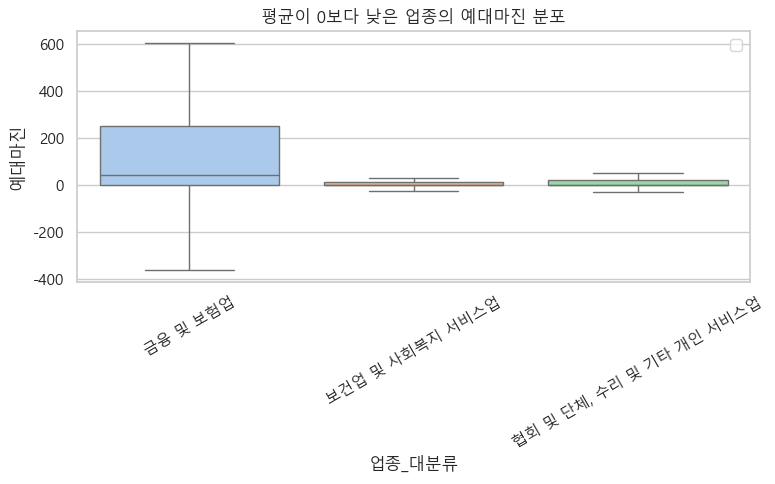

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=d_neg, x='업종_대분류', y='예대마진', showfliers=False, palette="pastel")
plt.title("평균이 0보다 낮은 업종의 예대마진 분포")
plt.ylabel("예대마진")
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()

먼저 값이 매우 큰 금융업

금융업에는 어떤 특성이 있을까? 지역별로 먼저 보자

### 서울 부산 금융업

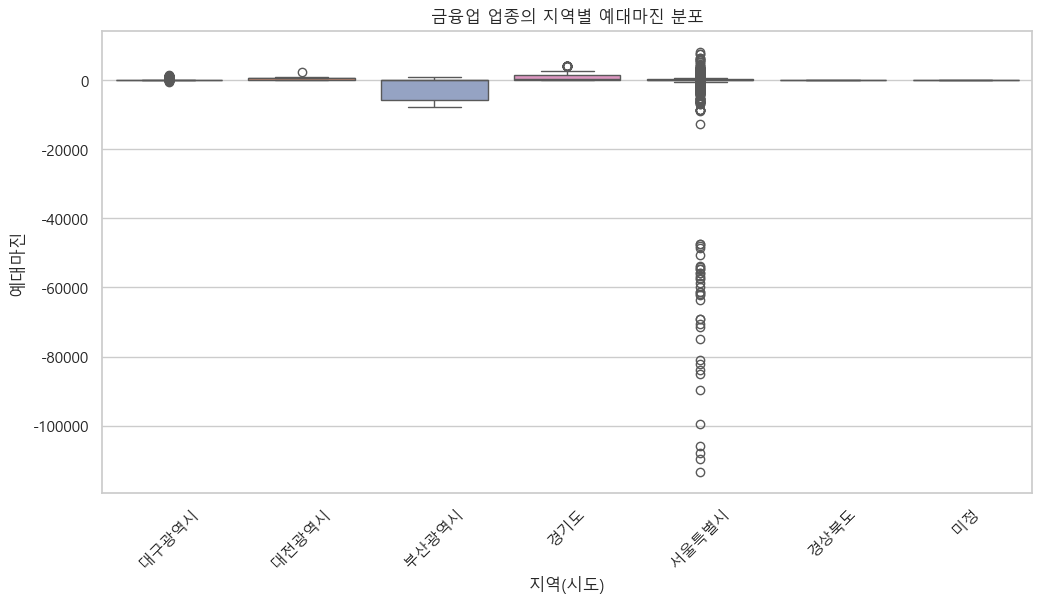

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False 

plt.figure(figsize=(12,6))
sns.boxplot(
    x="사업장_시도", 
    y="예대마진", 
    data=df[(df["업종_대분류"]=="금융 및 보험업")],
    palette="Set2"
)
plt.xticks(rotation=45)
plt.title("금융업 업종의 지역별 예대마진 분포")
plt.xlabel("지역(시도)")
plt.ylabel("예대마진")
plt.show()

금융업의 특성을 보아하니, 부산과 서울에 이런 현상이 많이 발생한다.

서울의 금융업의 극단값과 부산광역시의 분포를 보자

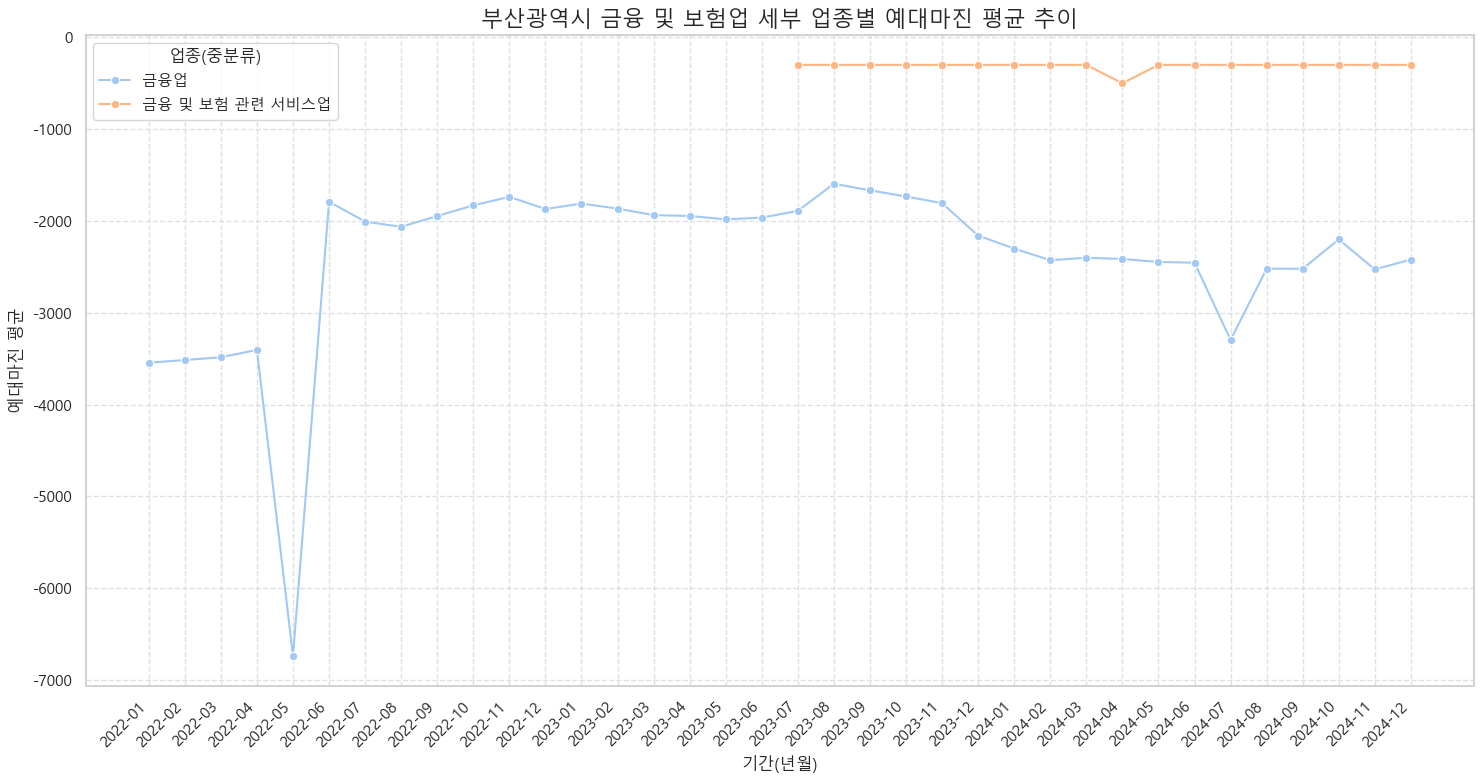

In [10]:
busan_df = df[df['사업장_시도'] == '부산광역시'].copy()
finance_df = busan_df[busan_df['업종_대분류'] == '금융 및 보험업'].copy()

finance_df['기준년월'] = finance_df['기준년월'].dt.strftime('%Y-%m')

avg_margin_by_sub_category = finance_df.groupby(['기준년월', '업종_중분류'])['예대마진'].mean().reset_index()

plt.figure(figsize=(15, 8))
sns.lineplot(
data=avg_margin_by_sub_category,
x='기준년월', 
y='예대마진', 
hue='업종_중분류',
marker='o'
)

plt.xticks(rotation=45, ha='right')
plt.title("부산광역시 금융 및 보험업 세부 업종별 예대마진 평균 추이", fontsize=16)
plt.xlabel("기간(년월)", fontsize=12)
plt.ylabel("예대마진 평균", fontsize=12)
plt.legend(title='업종(중분류)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [11]:
finance_df[finance_df['예대마진'] < -2000][['기준년월', '업종_대분류', '업종_중분류', '사업장_시도', '사업장_시군구', '법인_고객등급', '전담고객여부', '총잔액', '여신잔액']].sort_values(by='기준년월')

,기준년월,업종_대분류,업종_중분류,사업장_시도,사업장_시군구,법인_고객등급,전담고객여부,총잔액,여신잔액
319407,2022-01,금융 및 보험업,금융업,부산광역시,동구,최우수,False,362000.0,0.0
328846,2022-02,금융 및 보험업,금융업,부산광역시,동구,최우수,False,359000.0,0.0
338299,2022-03,금융 및 보험업,금융업,부산광역시,동구,최우수,False,356000.0,0.0
290858,2022-04,금융 및 보험업,금융업,부산광역시,동구,최우수,False,348000.0,0.0
300338,2022-05,금융 및 보험업,금융업,부산광역시,동구,최우수,False,337000.0,0.0
309921,2022-06,금융 및 보험업,금융업,부산광역시,동구,최우수,False,326000.0,0.0
261785,2022-07,금융 및 보험업,금융업,부산광역시,동구,최우수,False,321000.0,0.0
271492,2022-08,금융 및 보험업,금융업,부산광역시,동구,최우수,False,317000.0,0.0
281263,2022-09,금융 및 보험업,금융업,부산광역시,동구,최우수,False,312000.0,0.0
232545,2022-10,금융 및 보험업,금융업,부산광역시,동구,최우수,False,307000.0,0.0


In [12]:
df[df['예대마진'] < -40000][['기준년월', '업종_대분류', '업종_중분류', '사업장_시도', '사업장_시군구', '법인_고객등급', '전담고객여부', '총잔액', '여신잔액']].sort_values(by='기준년월')

,기준년월,업종_대분류,업종_중분류,사업장_시도,사업장_시군구,법인_고객등급,전담고객여부,총잔액,여신잔액
319391,2022-01,금융 및 보험업,금융업,서울특별시,중구,최우수,False,3778000.0,127000.00
328828,2022-02,금융 및 보험업,금융업,서울특별시,중구,최우수,False,3494000.0,127000.00
338281,2022-03,금융 및 보험업,금융업,서울특별시,중구,최우수,False,3188000.0,127000.00
290842,2022-04,금융 및 보험업,금융업,서울특별시,중구,최우수,False,3158000.0,127000.00
300321,2022-05,금융 및 보험업,금융업,서울특별시,중구,최우수,False,3028000.0,127000.00
309903,2022-06,금융 및 보험업,금융업,서울특별시,중구,최우수,False,2686000.0,127000.00
261767,2022-07,금융 및 보험업,금융업,서울특별시,중구,최우수,False,3101000.0,127000.66
271473,2022-08,금융 및 보험업,금융업,서울특별시,중구,최우수,False,3111000.0,127001.30
281245,2022-09,금융 및 보험업,금융업,서울특별시,중구,최우수,False,3051000.0,127002.00
232527,2022-10,금융 및 보험업,금융업,서울특별시,중구,최우수,False,3175000.0,127002.70


이 기업의 특징을 보아하니, 한 기업으로 추정되며, 최우수 등급이며 예금 보유액이 현저히 많다. 즉, 잠재고객군일 가능성이 있다.

보건업 및 사회복지 서비스업, 협회 및 단체, 수리 및 기타 개인 서비스업도 살펴 보자

### 보건업 

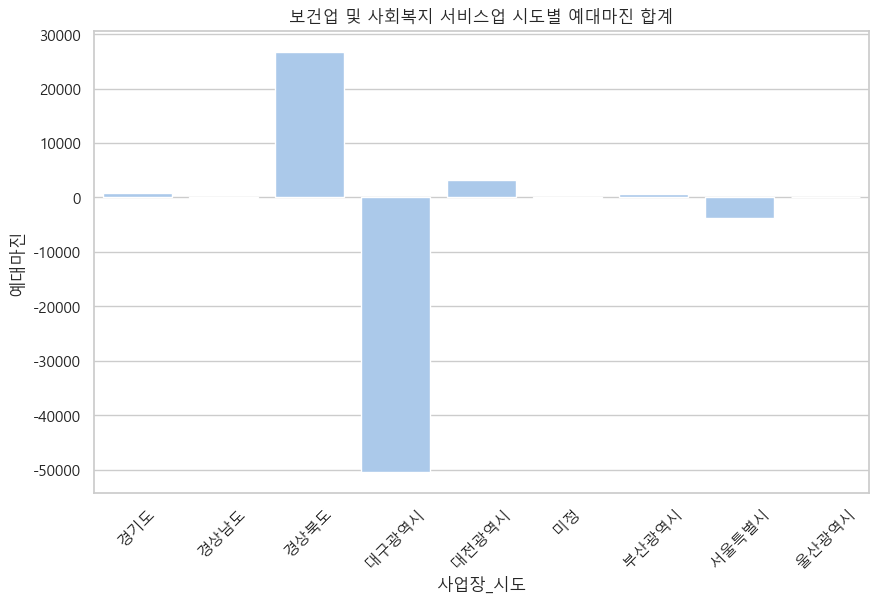

In [13]:
df_bogun = df[df['업종_대분류'] == '보건업 및 사회복지 서비스업']
df_bogun['기준년월'] = df_bogun['기준년월'].dt.strftime('%Y-%m')
df_bogun_grouped = df_bogun.groupby('사업장_시도').sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=df_bogun_grouped, x='사업장_시도', y='예대마진', ci=None, estimator=np.sum)
plt.xticks(rotation=45)
plt.title('보건업 및 사회복지 서비스업 시도별 예대마진 합계')
plt.show()

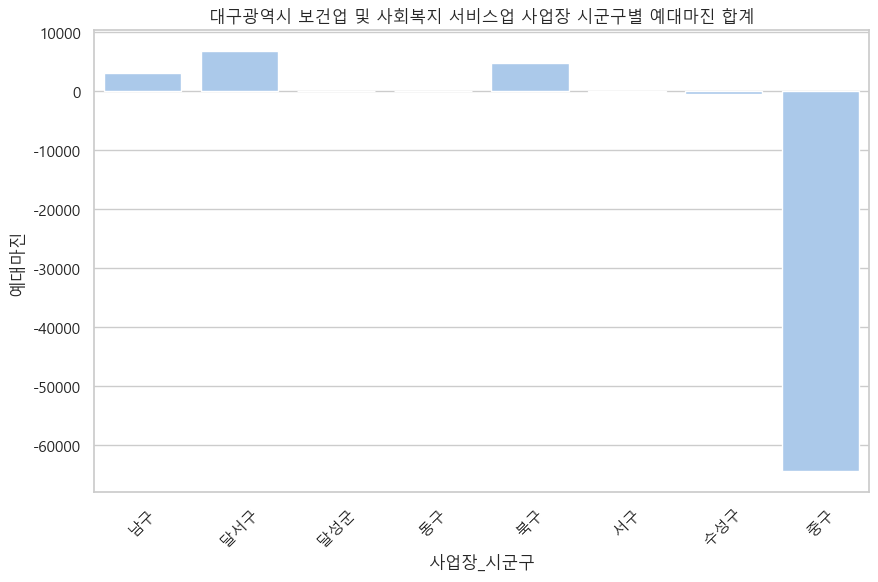

In [14]:
df_bogun_daegu = df_bogun[df_bogun['사업장_시도'] == '대구광역시']
df_bogun_daegu_grouped = df_bogun_daegu.groupby('사업장_시군구').sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=df_bogun_daegu_grouped, x='사업장_시군구', y='예대마진', ci=None, estimator=np.sum)
plt.xticks(rotation=45)
plt.title('대구광역시 보건업 및 사회복지 서비스업 사업장 시군구별 예대마진 합계')
plt.show()

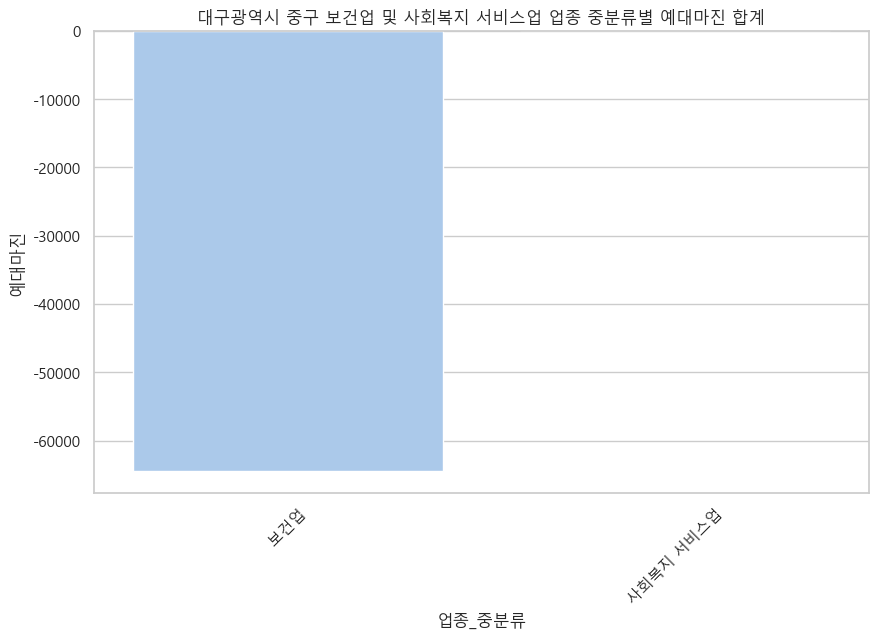

In [15]:
df_bogun_daegu_donggu = df_bogun_daegu[df_bogun_daegu['사업장_시군구'] == '중구']
df_bogun_daegu_donggu_grouped = df_bogun_daegu_donggu.groupby('업종_중분류').sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=df_bogun_daegu_donggu_grouped, x='업종_중분류', y='예대마진', ci=None, estimator=np.sum)
plt.xticks(rotation=45)
plt.title('대구광역시 중구 보건업 및 사회복지 서비스업 업종 중분류별 예대마진 합계')
plt.show()

In [16]:
df_bogun_daegu_donggu_bogun = df_bogun_daegu_donggu[df_bogun_daegu_donggu['업종_중분류'] == '보건업']
df_bogun_daegu_donggu_bogun

,기준년월,업종_대분류,업종_중분류,사업장_시도,사업장_시군구,법인_고객등급,전담고객여부,요구불예금잔액,거치식예금잔액,적립식예금잔액,...,여신잔액,외환거래총금액,수탁상품총잔액,카드사용총금액,여신이용률,디지털거래건수,디지털비중,창구비중,요구불회전율,예대마진
1132,2024-12,보건업 및 사회복지 서비스업,보건업,대구광역시,중구,최우수,True,50000.00,19000.0,0.0,...,0.0,0.0,9190.0,990.0,0.0,183,0.603960,0.198020,7.060000,-1380.0000
1133,2024-12,보건업 및 사회복지 서비스업,보건업,대구광역시,중구,최우수,True,8600.00,0.0,0.0,...,0.0,0.0,3200.0,55.0,0.0,156,0.647303,0.248963,0.953488,-172.0000
1135,2024-12,보건업 및 사회복지 서비스업,보건업,대구광역시,중구,일반,False,0.26,0.0,0.0,...,2.1,0.0,0.0,0.0,0.0,7,1.000000,0.000000,3.346154,0.0998
9746,2024-11,보건업 및 사회복지 서비스업,보건업,대구광역시,중구,최우수,True,33000.00,28000.0,0.0,...,0.0,0.0,8882.0,700.0,0.0,195,0.619048,0.190476,6.363636,-1220.0000
9747,2024-11,보건업 및 사회복지 서비스업,보건업,대구광역시,중구,최우수,True,8600.00,0.0,0.0,...,0.0,0.0,3200.0,52.0,0.0,155,0.645833,0.250000,1.732558,-172.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336704,2022-02,보건업 및 사회복지 서비스업,보건업,대구광역시,중구,일반,False,0.20,0.0,0.0,...,16.0,0.0,0.0,0.0,0.0,7,1.000000,0.000000,4.500000,0.7960
338390,2022-03,보건업 및 사회복지 서비스업,보건업,대구광역시,중구,최우수,True,78000.00,17000.0,0.0,...,0.0,0.0,9556.0,510.0,0.0,240,0.666667,0.166667,3.884615,-1900.0000
339869,2022-03,보건업 및 사회복지 서비스업,보건업,대구광역시,중구,최우수,True,31.00,0.0,0.0,...,0.0,0.0,15500.0,3.7,0.0,85,0.794393,0.065421,103.225806,-0.6200
343961,2022-03,보건업 및 사회복지 서비스업,보건업,대구광역시,중구,최우수,True,630.00,0.0,0.0,...,0.0,0.0,3400.0,28.0,0.0,157,0.623016,0.238095,4.761905,-12.6000


### 협회 및 단체, 수리 및 기타 개인 서비스업

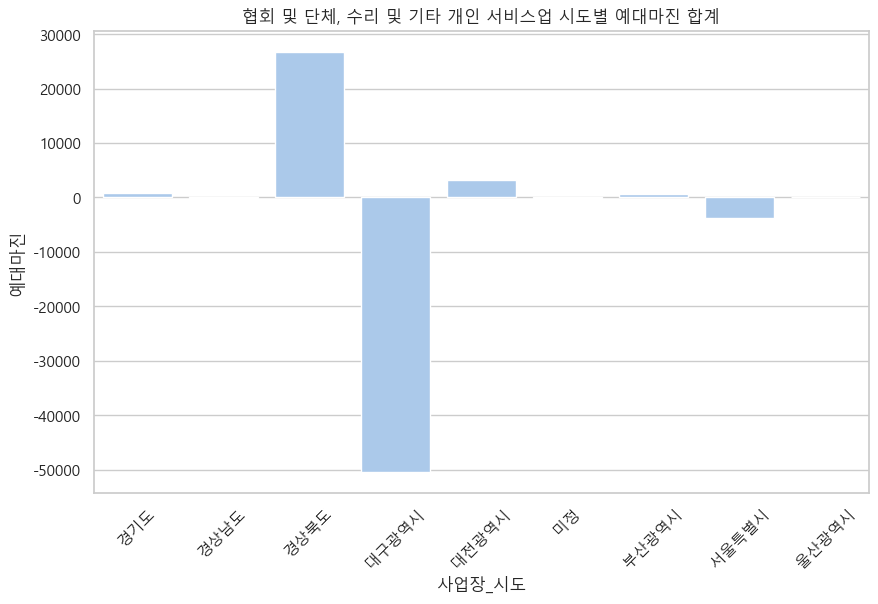

In [17]:
df_association = df[df['업종_대분류'] == '협회 및 단체, 수리 및 기타 개인 서비스업']
df_association['기준년월'] = df_association['기준년월'].dt.strftime('%Y-%m')

df_association_grouped = df_association.groupby('사업장_시도').sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=df_bogun_grouped, x='사업장_시도', y='예대마진', ci=None, estimator=np.sum)
plt.xticks(rotation=45)
plt.title('협회 및 단체, 수리 및 기타 개인 서비스업 시도별 예대마진 합계')
plt.show()

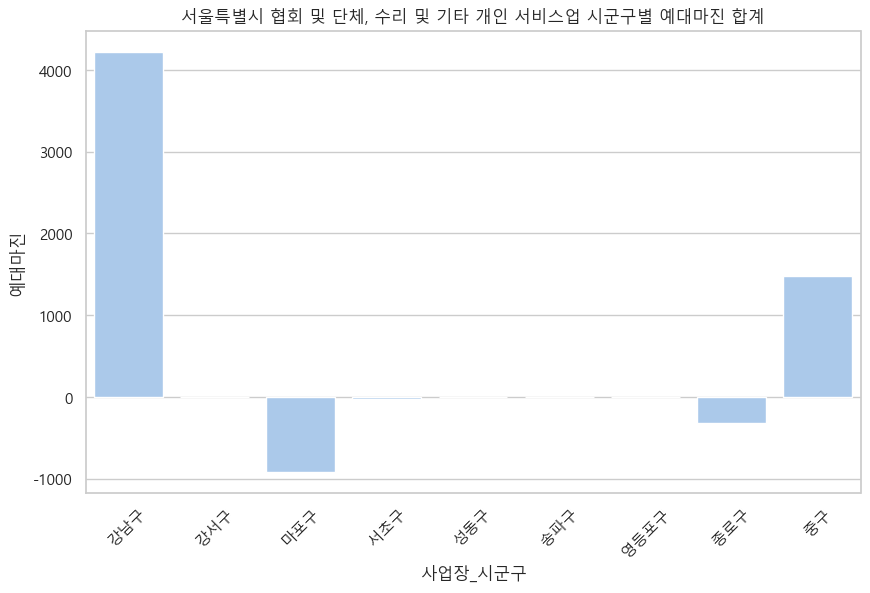

In [18]:
df_association_seoul = df_association[df_association['사업장_시도'] == '서울특별시']
df_association_seoul_grouped = df_association_seoul.groupby('사업장_시군구').sum(numeric_only=True).reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=df_association_seoul_grouped, x='사업장_시군구', y='예대마진', ci=None, estimator=np.sum)
plt.xticks(rotation=45)
plt.title('서울특별시 협회 및 단체, 수리 및 기타 개인 서비스업 시군구별 예대마진 합계')
plt.show()

,기준년월,업종_중분류,예대마진
320858,2022-01,협회 및 단체,103.400
320628,2022-01,기타 개인 서비스업,-1.540
330303,2022-02,협회 및 단체,84.000
330067,2022-02,기타 개인 서비스업,0.000
339736,2022-03,협회 및 단체,84.000
...,...,...,...
43379,2024-08,협회 및 단체,-0.124
34217,2024-09,협회 및 단체,-0.124
20712,2024-10,기타 개인 서비스업,-6.200
9770,2024-11,기타 개인 서비스업,-4.400


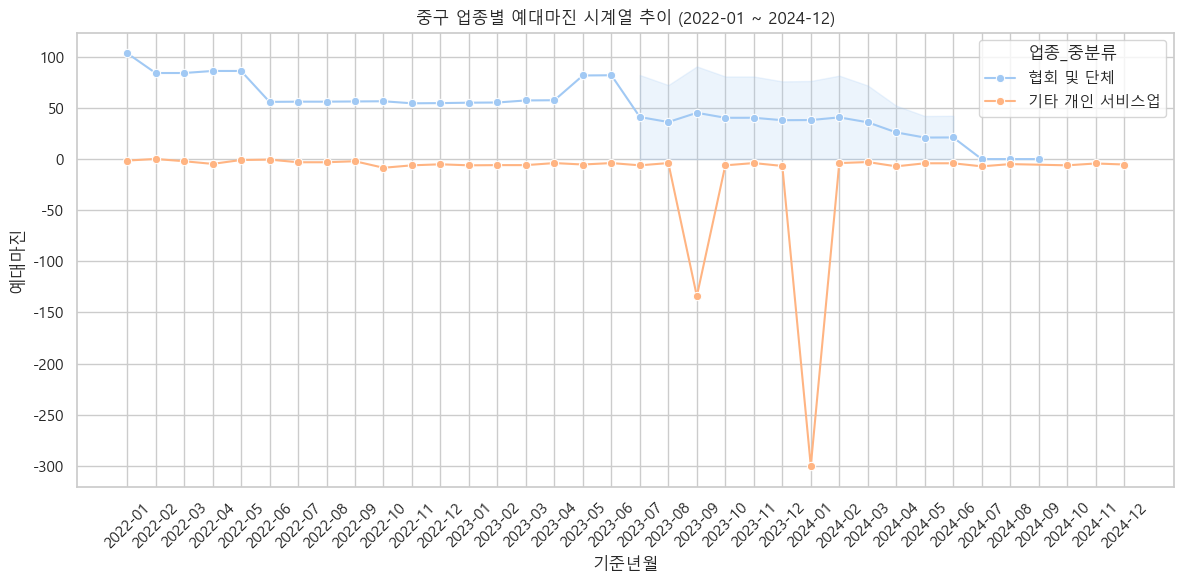

In [19]:
# '기준년월'을 기준으로 2022-01 ~ 2024-12까지 월별로 정렬해서 출력
df_association_seoul_junggu = df_association_seoul[df_association_seoul['사업장_시군구'] == '중구']
df_sorted = df_association_seoul_junggu.sort_values('기준년월')
display(df_sorted[['기준년월', '업종_중분류', '예대마진']])
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sorted, x='기준년월', y='예대마진', hue='업종_중분류', marker='o')
plt.title('중구 업종별 예대마진 시계열 추이 (2022-01 ~ 2024-12)')
plt.xlabel('기준년월')
plt.ylabel('예대마진')
plt.xticks(rotation=45)
plt.legend(title='업종_중분류')
plt.tight_layout()
plt.show()

In [20]:
# '기타 개인 서비스업' 중 예대마진이 음수이고, 서울특별시인 데이터만 추출 (기준년월 기준 정렬)
cond_seoul = (
    (df['업종_중분류'] == '기타 개인 서비스업') &
    (df['예대마진'] < 0) &
    (df['사업장_시도'] == '서울특별시')
)
df_etc_neg_seoul = df[cond_seoul].copy()
df_etc_neg_seoul = df_etc_neg_seoul.sort_values('기준년월')
print(f'기타 개인 서비스업 중 예대마진 음수 & 서울특별시 데이터 건수: {len(df_etc_neg_seoul)}')
display(df_etc_neg_seoul[['기준년월','업종_대분류','업종_중분류','사업장_시도','사업장_시군구','법인_고객등급','예대마진','총잔액','여신잔액']].head(35))

기타 개인 서비스업 중 예대마진 음수 & 서울특별시 데이터 건수: 34


,기준년월,업종_대분류,업종_중분류,사업장_시도,사업장_시군구,법인_고객등급,예대마진,총잔액,여신잔액
320628,2022-01,"협회 및 단체, 수리 및 기타 개인 서비스업",기타 개인 서비스업,서울특별시,중구,최우수,-1.54,77.0,0.0
339507,2022-03,"협회 및 단체, 수리 및 기타 개인 서비스업",기타 개인 서비스업,서울특별시,중구,최우수,-2.20,110.0,0.0
292085,2022-04,"협회 및 단체, 수리 및 기타 개인 서비스업",기타 개인 서비스업,서울특별시,중구,최우수,-4.80,240.0,0.0
301565,2022-05,"협회 및 단체, 수리 및 기타 개인 서비스업",기타 개인 서비스업,서울특별시,중구,최우수,-1.00,50.0,0.0
311123,2022-06,"협회 및 단체, 수리 및 기타 개인 서비스업",기타 개인 서비스업,서울특별시,중구,최우수,-0.60,30.0,0.0
262992,2022-07,"협회 및 단체, 수리 및 기타 개인 서비스업",기타 개인 서비스업,서울특별시,중구,최우수,-3.20,160.0,0.0
272695,2022-08,"협회 및 단체, 수리 및 기타 개인 서비스업",기타 개인 서비스업,서울특별시,중구,최우수,-3.20,160.0,0.0
282450,2022-09,"협회 및 단체, 수리 및 기타 개인 서비스업",기타 개인 서비스업,서울특별시,중구,최우수,-2.20,110.0,0.0
233744,2022-10,"협회 및 단체, 수리 및 기타 개인 서비스업",기타 개인 서비스업,서울특별시,중구,최우수,-8.60,430.0,0.0
243504,2022-11,"협회 및 단체, 수리 및 기타 개인 서비스업",기타 개인 서비스업,서울특별시,중구,최우수,-6.20,310.0,0.0


### 결론

보건업 및 사회복지 서비스업, 협회 및 단체, 수리 및 기타 개인 서비스업도 같은 패턴을 보인다.

즉, 예금은 많으나 대출이 거의 없어 예대마진이 음수인 고객군 존재하며 구조적 적자 고객군 존재 확인

예대마진만 보면 저수익 고객으로 분류되지만, 이들은 조달 안정성 기여도가 매우 높은 전략 고객

대출 확장보다 수탁·투자상품 결합 + 디지털 채널 교차판매로 은행 수익성 극대화해야 하며, 

